# Installation

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 17.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 15.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=68697d6e2155860bd46a700670efd1a76556c3a266bc9c7fa9a2f449591dc7ee
  Stored in directory: /root/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=23690f22b23a824e34cabc42fc05601f0756ab89c02fcbe02e1192800a7d9770
  Stored in directory: /root/.cache/pip/w

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
!unzip "/content/drive/MyDrive/Takeout/takeout-20221225T104018Z-001.zip" -d "/content"

Archive:  /content/drive/MyDrive/Takeout/takeout-20221225T104018Z-001.zip
  inflating: /content/Takeout/Drive/Data/Validation/Video16_frame009440.npz  
  inflating: /content/Takeout/Drive/Data/Validation/Video16_frame005640.npz  
  inflating: /content/Takeout/Drive/Data/Testing/Video22_frame013270.npz  
  inflating: /content/Takeout/Drive/Data/Validation/Video5_frame002610.npz  
  inflating: /content/Takeout/Drive/Data/Testing/Video2_frame000990.npz  
  inflating: /content/Takeout/Drive/Data/Testing/Video12_frame011720.npz  
  inflating: /content/Takeout/Drive/Data/Testing/Video22_frame011250.npz  
  inflating: /content/Takeout/Drive/Data/Validation/Video16_frame006560.npz  
  inflating: /content/Takeout/Drive/Data/Validation/Video5_frame010240.npz  
  inflating: /content/Takeout/Drive/Data/Validation/Video5_frame008550.npz  
  inflating: /content/Takeout/Drive/Data/Validation/Video7_frame000850.npz  
  inflating: /content/Takeout/Drive/Data/Validation/Video16_frame016790.npz  
  infla

In [5]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 


from tqdm import tqdm

import os 
import copy
import glob


In [6]:

DEVICE = 'cuda' #Cuda as using GPU

EPOCHS = 50 #25 training iterations
LR = 0.001 #decay learning rate
IMAGE_SIZE = 320
HEIGHT = 288
WIDTH = 480
BATCH_SIZE = 4
NO_OF_IMAGES = 100
# Images are irregular shape so need to resize

ENCODER = 'resnet34' 
WEIGHTS = 'imagenet' #use weights from imagenet



In [7]:
import random
training_images = (glob.glob(f"/content/Takeout/Drive/Data/Training/*.npz"))
# for i in range (0, len(training_images)):
#   training_images[i] = os.path.basename(training_images[i]).replace(".npz", "")


training_images = training_images[:100]


testing_images = (glob.glob(f"/content/Takeout/Drive/Data/Testing/*.npz"))
# for i in range (0, len(testing_images)):
#   testing_images[i] = os.path.basename(testing_images[i]).replace(".npz", "")


validation_images = (glob.glob(f"/content/Takeout/Drive/Data/Validation/*.npz"))
# for i in range (0, len(validation_images)):
#   validation_images[i] = os.path.basename(validation_images[i]).replace(".npz", "")


validation_images = validation_images[:100]





# Set up model

In [9]:
from torch import nn # neural netowrk 
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss, LovaszLoss, FocalLoss, JaccardLoss



In [10]:
from math import log

class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__() 

    self.architecture = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS, 
        in_channels = 3, #Input is RGB
        classes = 8, # binary segmentation problem 
        activation = None #no sigmoid or softmax

    )
  
  def show(self):
    return self.architecture

  def forward(self, images, masks = None):
    logits = self.architecture(images) #probabilities / predictions
   
    
    if masks!= None:
      weights = [4.116647326424263, 24.600245093614593, 191.78790779880697, 240.94195047235274, 7.334747505863925, 10.620043927212807, 2.219872768361696, 38.32265526553685]

      class_weights=torch.tensor(weights,dtype=torch.float).to(DEVICE)
      lovasz = LovaszLoss(mode = 'multiclass')(logits, masks)
      #loss_fn = nn.CrossEntropyLoss()#binary cross entropy loss

      loss = lovasz
      return logits, loss

    return logits


In [11]:
model = SegmentationModel()
model.to(DEVICE); #i.e CUDA

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [12]:
from torch import nn, optim
import torchvision.models as models
import torch.nn.functional as f


class Initializer(nn.Module):
	def __init__(self):
		super(Initializer, self).__init__()
		self.new_layer = nn.Conv2d(in_channels=4, out_channels=64, kernel_size=3)
		

		self.pretrained_model = models.vgg16(pretrained=True)
		self.model = nn.Sequential(*list(self.pretrained_model.features.children())[2:31])
		self.interp = nn.functional.interpolate

		self.c0 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1)
		

		self.h0 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1)
		
		self.relu = nn.ReLU()

	def forward(self, inputs):
		x = self.relu(self.new_layer(inputs))
		x = self.model(x)
		c0 = self.relu(self.c0(x))
		h0 = self.relu(self.h0(x))
		c0 = self.interp(c0, size=(9,15), mode='bilinear', align_corners=False)
		h0 = self.interp(h0, size=(9,15), mode='bilinear', align_corners=False)
		return c0,h0

class ConvLSTMCell(nn.Module):
    """
    Generate a convolutional LSTM cell
    """

    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.conv = nn.Conv2d(input_size + hidden_size, 4 * hidden_size, 3, padding=3 // 2)

    def forward(self, input_, hiddenState, cellState):
        

        prev_hidden = hiddenState
        prev_cell = cellState

        # data size is [batch, channel, height, width]
        stacked_inputs = torch.cat((input_, prev_hidden), 1)
        combined_conv = self.conv(stacked_inputs)

        # chunk across channel dimension -> get conv inputs
        in_gate, remember_gate, out_gate, cell_gate = combined_conv.chunk(4, 1)

        # apply sigmoid non linearity 
        in_gate = torch.sigmoid(in_gate)
        remember_gate = torch.sigmoid(remember_gate)
        out_gate = torch.sigmoid(out_gate)

        # apply tanh non linearity instead of sigmoid
        cell_gate = f.relu(cell_gate)

        # compute current cell and hidden state
        cell = (remember_gate * prev_cell) + (in_gate * cell_gate)
        hidden = out_gate * f.relu(cell)

        return hidden, cell




In [13]:
class LSTMModel(nn.Module):
    def __init__(self, initializer, encoder,convlstm,decoder):
        super(LSTMModel, self).__init__()
        self.initializer = initializer
        self.encoder = encoder
        self.convlstm = convlstm
        self.decoder = decoder
    
    def getInitializer(self):
      return self.initializer

    def getLSTM(self):
      return self.convlstm
    
    def getEncoder(self):
      return self.encoder

    def getDecoder(self):
      return self.decoder

    
  
  
    def forward(self, images, masks):
      logits = []
      mask = masks[0]
      first_image = images[0]
      first_image = first_image.to(DEVICE).unsqueeze(0)
      
      mask = mask.to(DEVICE).unsqueeze(0)
      mask = mask.unsqueeze(0)
      #mask = np.swapaxes(mask,1,2)

   

      c0,h0 = initializer(torch.cat((first_image,mask),1))

      for i in range(1,len(images)):
        image = images[i,:,:,:].cuda()
        image = image.to(DEVICE).unsqueeze(0)

        x_tilda = encoder(image)
        features = x_tilda
        feature_vector = x_tilda[5]
        c_next,h_next = convlstm(feature_vector, h0, c0)
        decoder = model_summary.decoder

        features[5] = h_next
        decoder_output = decoder(*features)
        c0 = c_next
        h0 = h_next
        
        logits_mask = model_summary.segmentation_head(decoder_output)
        logits_mask = logits_mask.squeeze(0)
        logits.append(logits_mask)
        
      logits = torch.stack(logits)

      logits = logits.transpose(1,0) # makes in the dimension of classes, no of images, width, height so 8,7,480,288
      
      return logits

        
  

# Set up dataset and data loader

In [14]:
# increases more images for training dataset
from albumentations.pytorch import ToTensorV2
import albumentations as A

def get_train_augs():
  return A.Compose([
      A.RandomCrop(height=192, width=320, p=0.2),
      A.Resize(height = HEIGHT, width = WIDTH),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5),
      A.GaussianBlur(blur_limit=3, p=0.5),
      A.ColorJitter (brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.3),
      ToTensorV2(),

      
      
  ], additional_targets={'image1': 'image', 'image2': 'image', 'image3': 'image', 'image4': 'image', 'image5': 'image', 'image6': 'image'
  ,'mask1': 'mask', 'mask2': 'mask', 'mask3': 'mask', 'mask4': 'mask', 'mask5': 'mask', 'mask6': 'mask' })


# for validation and test set
def get_valid_augs():
  return A.Compose([
      
      ToTensorV2()
      
  ], additional_targets={'image1': 'image', 'image2': 'image', 'image3': 'image', 'image4': 'image', 'image5': 'image', 'image6': 'image'
  ,'mask1': 'mask', 'mask2': 'mask', 'mask3': 'mask', 'mask4': 'mask', 'mask5': 'mask', 'mask6': 'mask' })

def get_test_augs():
  return A.Compose([
      
      ToTensorV2()
      
  ], additional_targets={'image1': 'image', 'image2': 'image', 'image3': 'image', 'image4': 'image', 'image5': 'image', 'image6': 'image'
  ,'mask1': 'mask', 'mask2': 'mask', 'mask3': 'mask', 'mask4': 'mask', 'mask5': 'mask', 'mask6': 'mask' })

In [15]:
from torch.utils.data import Dataset


class SegmentationDataset(Dataset):

  def __init__(self, split, augmentations, sequence):
   # self.df = df
    self.split = split
    self.augmentations = augmentations
    self.sequence = sequence
  
  def __len__(self):
    return len(self.sequence)
  

  def __getitem__(self, idx):
    # image_name = self.sequence[idx]
    # images, masks = generateImagesMasks(image_name, self.split)
    path = self.sequence[idx]
    array = np.load(path)
    images = array['images']
    masks = array['masks']
    #print(set(masks[0].flatten()))

    images = np.transpose(images, (0, 2,3,1))
    transformed_images = []
    transformed_masks = []

    
   

    if self.augmentations:
      data = self.augmentations(image=images[0],image1=images[1],image2=images[2],image3=images[3],image4=images[4],image5=images[5],
                                image6=images[6], mask=masks[0], mask1=masks[1], mask2=masks[2], mask3=masks[3], mask4=masks[4], mask5=masks[5],mask6=masks[6])
     
      

      transformed_images.append(data['image'])
      transformed_images.append(data['image1'])
      transformed_images.append(data['image2'])
      transformed_images.append(data['image3'])
      transformed_images.append(data['image4'])
      transformed_images.append(data['image5'])
      transformed_images.append(data['image6'])

      transformed_masks.append(data['mask'])
      transformed_masks.append(data['mask1'])
      transformed_masks.append(data['mask2'])
      transformed_masks.append(data['mask3'])
      transformed_masks.append(data['mask4'])
      transformed_masks.append(data['mask5'])
      transformed_masks.append(data['mask6'])
      
      
      transformed_images = torch.stack(transformed_images)
      transformed_masks = torch.stack(transformed_masks)
      return transformed_images, transformed_masks
    
    
    # masks = getMaskSequence(transformed_images, mask)


    return images, masks


In [16]:
trainset = SegmentationDataset("Training", get_train_augs(), training_images)
validset = SegmentationDataset("Validation", get_valid_augs(), validation_images)
testset = SegmentationDataset("Testing", get_test_augs(), testing_images)


/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/blur/transforms.py:184: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


In [17]:
from torch.utils.data import DataLoader
trainloader = DataLoader(trainset, batch_size = 4, shuffle = True,num_workers=2,pin_memory=True) #every epoch batches shuffles
validloader = DataLoader(validset, batch_size = 4, shuffle = True,num_workers=2)

# Set up training and validation

In [25]:
from torch.autograd import Variable

def train_function(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE, dtype=torch.long)
    
    
    # make sure gradients are 0
    optimizer.zero_grad()
    logits = []
    triplet_sequences = []
    for i in range (0, len(images)):
      logits_mask = model(images[i], masks[i])
      logits.append(logits_mask)
      triplet_sequences.append(logits_mask.flatten())
        
    logits = torch.stack(logits)
    triplet_sequences = torch.stack(triplet_sequences)

    losses = []
    loss = 0
    count = 0
   
    weights =  [0.6, 0.9, 1.0, 0.9, 0.6, 0.1]
    
    for i in range (0, 6):
      logit = logits[:,:,i,:,:] #iterate per frame
      mask = masks[:,i,:,:]
      mask = mask.contiguous()
      loss_per_frame = LovaszLoss(mode = 'multiclass', ignore_index=-1)(logit, mask)

      loss += loss_per_frame * weights[i]
      count+= weights[i]


    loss = loss / count

    # calculate triplet loss 
    print(logits.shape)


    

    loss.backward() #backpropagation

    optimizer.step() #update weights

    total_loss += loss.item()

  return total_loss / len(data_loader)



In [19]:
def eval_function(data_loader, model):

  model.eval() 
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE, dtype=torch.long)
      logits = []
      for i in range (0, len(images)):
        logits.append(model(images[i], masks[i]))
      logits = torch.stack(logits)
      losses = []
      loss = 0
      count = 0
      weights =  [0.6, 0.9, 1.0, 0.9, 0.6, 0.1]
    
      for i in range (0, 6):
        logit = logits[:,:,i,:,:] #iterate per frame
        mask = masks[:,i,:,:]
        mask = mask.contiguous()
        loss_per_frame = LovaszLoss(mode = 'multiclass', ignore_index=-1)(logit, mask)

        loss += loss_per_frame * weights[i]
        count+= weights[i]

      loss = loss / count



      total_loss += loss.item()

  return total_loss / len(data_loader)

# Training model

In [20]:
model.load_state_dict(torch.load('/content/drive/My Drive/Dissertation/best_model_aug.pt'))
model_summary = model.show()
encoder = model_summary.encoder
initializer = Initializer()
decoder = model_summary.decoder

for name,param in encoder.named_parameters():
  param.requires_grad = False

for name,param in decoder.named_parameters():
  param.requires_grad = False


convlstm  = ConvLSTMCell(input_size = 512, hidden_size = 512)
new_model = LSTMModel(initializer,encoder,convlstm,decoder)
new_model.cuda()




LR = 0.00001
optimizer = torch.optim.Adam(new_model.parameters(), lr = LR)
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 0.00001, 0.001,5, cycle_momentum = False, mode='exp_range', gamma = 0.98)
lambda1 = lambda1 = lambda epoch : pow((1 - epoch / EPOCHS), 0.9)
# #scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer,lambda1) #polynomial
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95, last_epoch=- 1, verbose=False)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
import gc
#new_model.cpu()
model.cpu()
#del new_model
del model
gc.collect()
torch.cuda.empty_cache()


In [ ]:

EPOCHS = 30
best_valid_loss = np.Inf

valid_losses = []
train_losses = []

lrs = []


number_epoch_to_save = 5

for epoch in range(0,EPOCHS):


  train_loss = train_function(trainloader, new_model, optimizer)
  valid_loss = eval_function(validloader, new_model)
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)


  if valid_loss < best_valid_loss: #if best valid loss then upate new model
    torch.save(new_model.state_dict(), f'/content/drive/My Drive/Dissertation/conv_lstm_2.pt')
    print("Saved model")
    best_valid_loss = valid_loss

  #scheduler.step()



  if epoch % number_epoch_to_save == 0:

    torch.save({
              'epoch': epoch,
              'model_state_dict': new_model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': valid_loss,
              'best_loss': best_valid_loss,
              'train_loss': train_loss
              }, '/content/drive/My Drive/Dissertation/conv_lstm_current_2.pt')
  
  #lrs.append(scheduler.get_last_lr())
  
  print(f"Epoch : {epoch+1} Train_loss : {train_loss} Valid_loss : {valid_loss} Learning rate:  ")



100%|██████████| 134/134 [01:39<00:00,  1.34it/s]


Saved model
Epoch : 1 Train_loss : 0.26051253635647165 Valid_loss : 0.2036854799336462 Learning rate:  


100%|██████████| 134/134 [01:39<00:00,  1.35it/s]


Saved model
Epoch : 2 Train_loss : 0.2325716516758614 Valid_loss : 0.19769375726803026 Learning rate:  


100%|██████████| 134/134 [01:39<00:00,  1.35it/s]


Epoch : 3 Train_loss : 0.22544997971821226 Valid_loss : 0.1985671454623564 Learning rate:  


100%|██████████| 134/134 [01:39<00:00,  1.34it/s]


Saved model
Epoch : 4 Train_loss : 0.21905660031820243 Valid_loss : 0.19284178505637753 Learning rate:  


100%|██████████| 134/134 [01:38<00:00,  1.36it/s]


Saved model
Epoch : 5 Train_loss : 0.21897522280133278 Valid_loss : 0.1881637266322748 Learning rate:  


100%|██████████| 134/134 [01:39<00:00,  1.35it/s]


Epoch : 6 Train_loss : 0.2148849676222593 Valid_loss : 0.1897869350305244 Learning rate:  


100%|██████████| 134/134 [01:38<00:00,  1.36it/s]


Epoch : 7 Train_loss : 0.21057795758693004 Valid_loss : 0.23022016560408606 Learning rate:  


100%|██████████| 134/134 [01:39<00:00,  1.34it/s]


Saved model
Epoch : 8 Train_loss : 0.21345036412712257 Valid_loss : 0.18148517486319612 Learning rate:  


100%|██████████| 134/134 [01:39<00:00,  1.34it/s]


Epoch : 9 Train_loss : 0.20683792165814424 Valid_loss : 0.18231885757908892 Learning rate:  


100%|██████████| 134/134 [01:39<00:00,  1.35it/s]


Epoch : 10 Train_loss : 0.2010776278879142 Valid_loss : 0.18779074522986342 Learning rate:  


100%|██████████| 134/134 [01:39<00:00,  1.34it/s]


Saved model
Epoch : 11 Train_loss : 0.2056917248662772 Valid_loss : 0.1784573746706123 Learning rate:  


100%|██████████| 134/134 [01:39<00:00,  1.34it/s]


Epoch : 12 Train_loss : 0.20119845045660184 Valid_loss : 0.18350801405621997 Learning rate:  


100%|██████████| 134/134 [01:40<00:00,  1.33it/s]


Epoch : 13 Train_loss : 0.2019681975263048 Valid_loss : 0.18231049124429474 Learning rate:  


100%|██████████| 134/134 [01:39<00:00,  1.35it/s]


Saved model
Epoch : 14 Train_loss : 0.20034812188724865 Valid_loss : 0.1761847043882555 Learning rate:  


100%|██████████| 134/134 [01:39<00:00,  1.34it/s]


Saved model
Epoch : 15 Train_loss : 0.20080786990880403 Valid_loss : 0.17577905269033872 Learning rate:  


100%|██████████| 134/134 [01:39<00:00,  1.35it/s]


Epoch : 16 Train_loss : 0.19679591428699358 Valid_loss : 0.1868392333610734 Learning rate:  


100%|██████████| 134/134 [01:39<00:00,  1.34it/s]


Epoch : 17 Train_loss : 0.1947026221028898 Valid_loss : 0.18110068842991076 Learning rate:  


100%|██████████| 134/134 [01:39<00:00,  1.34it/s]


Saved model
Epoch : 18 Train_loss : 0.19503127616601731 Valid_loss : 0.17419645601688927 Learning rate:  


100%|██████████| 134/134 [01:39<00:00,  1.35it/s]


Epoch : 19 Train_loss : 0.1970141502536552 Valid_loss : 0.19342666942237027 Learning rate:  


100%|██████████| 134/134 [01:39<00:00,  1.34it/s]


Saved model
Epoch : 20 Train_loss : 0.1943359663534277 Valid_loss : 0.1721395284715873 Learning rate:  


100%|██████████| 134/134 [01:39<00:00,  1.35it/s]


Epoch : 21 Train_loss : 0.19554797589849188 Valid_loss : 0.1989851242570735 Learning rate:  


100%|██████████| 134/134 [01:39<00:00,  1.34it/s]


Epoch : 22 Train_loss : 0.19421848472875525 Valid_loss : 0.17972984676485632 Learning rate:  


100%|██████████| 134/134 [01:40<00:00,  1.34it/s]


Saved model
Epoch : 23 Train_loss : 0.1937473607249558 Valid_loss : 0.1696134686692437 Learning rate:  


100%|██████████| 134/134 [01:39<00:00,  1.35it/s]


Saved model
Epoch : 24 Train_loss : 0.1924670717222089 Valid_loss : 0.1685443644536965 Learning rate:  


100%|██████████| 134/134 [01:39<00:00,  1.35it/s]


Epoch : 25 Train_loss : 0.19111971481580217 Valid_loss : 0.16993048414587975 Learning rate:  


 17%|█▋        | 146/848 [03:20<15:54,  1.36s/it]

In [ ]:
checkpoint = torch.load('/content/drive/My Drive/Dissertation/conv_lstm_current_2.pt')
new_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch_start = checkpoint['epoch']
valid_loss = checkpoint['loss']
best_valid_loss = checkpoint['best_loss']
train_loss = checkpoint['train_loss']

valid_losses = []
train_losses = []

lrs = []


number_epoch_to_save = 5

for epoch in range(0,EPOCHS):


  train_loss = train_function(trainloader, new_model, optimizer)
  valid_loss = eval_function(validloader, new_model)
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)


  if valid_loss < best_valid_loss: #if best valid loss then upate new model
    torch.save(new_model.state_dict(), f'/content/drive/My Drive/Dissertation/conv_lstm_3.pt')
    print("Saved model")
    best_valid_loss = valid_loss

  #scheduler.step()



  if epoch % number_epoch_to_save == 0:

    torch.save({
              'epoch': epoch,
              'model_state_dict': new_model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': valid_loss,
              'best_loss': best_valid_loss,
              'train_loss': train_loss
              }, '/content/drive/My Drive/Dissertation/conv_lstm_current_2.pt')
  
  #lrs.append(scheduler.get_last_lr())
  
  print(f"Epoch : {epoch+1} Train_loss : {train_loss} Valid_loss : {valid_loss} Learning rate:  ")


100%|██████████| 134/134 [01:44<00:00,  1.28it/s]


Epoch : 1 Train_loss : 0.1846673905339865 Valid_loss : 0.16807919896360654 Learning rate:  


100%|██████████| 134/134 [01:43<00:00,  1.29it/s]


Epoch : 2 Train_loss : 0.1872788268791617 Valid_loss : 0.19164283818273403 Learning rate:  


100%|██████████| 134/134 [01:43<00:00,  1.29it/s]


Saved model
Epoch : 3 Train_loss : 0.18802435882389545 Valid_loss : 0.16603205731110787 Learning rate:  


100%|██████████| 134/134 [01:43<00:00,  1.29it/s]


Saved model
Epoch : 4 Train_loss : 0.1857233613044164 Valid_loss : 0.16596713339659705 Learning rate:  


100%|██████████| 134/134 [01:43<00:00,  1.29it/s]


Saved model
Epoch : 5 Train_loss : 0.1840636452993835 Valid_loss : 0.1651764310785194 Learning rate:  


100%|██████████| 134/134 [01:44<00:00,  1.29it/s]


Epoch : 6 Train_loss : 0.18407191602372616 Valid_loss : 0.1856192671763363 Learning rate:  


100%|██████████| 134/134 [01:44<00:00,  1.28it/s]


Epoch : 7 Train_loss : 0.18536094924048432 Valid_loss : 0.17111318280447774 Learning rate:  


100%|██████████| 134/134 [01:45<00:00,  1.27it/s]


Epoch : 8 Train_loss : 0.1832615681221041 Valid_loss : 0.16535682876163454 Learning rate:  


100%|██████████| 134/134 [01:44<00:00,  1.28it/s]


Epoch : 9 Train_loss : 0.18375355502555393 Valid_loss : 0.17496287961726759 Learning rate:  


100%|██████████| 134/134 [01:44<00:00,  1.28it/s]


Epoch : 10 Train_loss : 0.1832970324112981 Valid_loss : 0.17433584403635852 Learning rate:  


100%|██████████| 134/134 [01:44<00:00,  1.28it/s]


Epoch : 11 Train_loss : 0.1833461220024751 Valid_loss : 0.170960889156185 Learning rate:  


100%|██████████| 134/134 [01:44<00:00,  1.28it/s]


Saved model
Epoch : 12 Train_loss : 0.17946241046565603 Valid_loss : 0.16373205084854098 Learning rate:  


100%|██████████| 134/134 [01:44<00:00,  1.28it/s]


Epoch : 13 Train_loss : 0.18325464582984458 Valid_loss : 0.1645074432243162 Learning rate:  


100%|██████████| 134/134 [01:44<00:00,  1.28it/s]


Epoch : 14 Train_loss : 0.18376724220777177 Valid_loss : 0.16731549187827466 Learning rate:  


100%|██████████| 134/134 [01:44<00:00,  1.28it/s]


Epoch : 15 Train_loss : 0.1833083711845695 Valid_loss : 0.1776666607874543 Learning rate:  


100%|██████████| 134/134 [01:44<00:00,  1.28it/s]


Saved model
Epoch : 16 Train_loss : 0.1807200716597573 Valid_loss : 0.1622166146538151 Learning rate:  


100%|██████████| 134/134 [01:44<00:00,  1.29it/s]


Epoch : 17 Train_loss : 0.18176556404961167 Valid_loss : 0.17172287938310138 Learning rate:  


100%|██████████| 134/134 [01:44<00:00,  1.28it/s]


Epoch : 18 Train_loss : 0.18317128011499936 Valid_loss : 0.165294161316619 Learning rate:  


100%|██████████| 134/134 [01:44<00:00,  1.28it/s]


Epoch : 19 Train_loss : 0.18054786475621304 Valid_loss : 0.16400662926373197 Learning rate:  


100%|██████████| 134/134 [01:43<00:00,  1.29it/s]


Epoch : 20 Train_loss : 0.18028877252045106 Valid_loss : 0.163737908895336 Learning rate:  


100%|██████████| 134/134 [01:45<00:00,  1.27it/s]


Epoch : 21 Train_loss : 0.1798006451846856 Valid_loss : 0.16227573567806786 Learning rate:  


100%|██████████| 134/134 [01:44<00:00,  1.28it/s]


Epoch : 22 Train_loss : 0.17936564223700255 Valid_loss : 0.16307318160560594 Learning rate:  


100%|██████████| 134/134 [01:45<00:00,  1.27it/s]


Epoch : 23 Train_loss : 0.18104094927603342 Valid_loss : 0.16552757549641736 Learning rate:  


100%|██████████| 134/134 [01:43<00:00,  1.29it/s]


Epoch : 24 Train_loss : 0.17896015406146926 Valid_loss : 0.16856502013197586 Learning rate:  


  5%|▌         | 43/848 [01:02<19:25,  1.45s/it]


KeyboardInterrupt: ignored

# Only training conv lstm and decoder + encoder

In [ ]:
new_model.load_state_dict(torch.load('/content/drive/My Drive/Dissertation/conv_lstm_4.pt'))

<All keys matched successfully>

In [ ]:
encoder = new_model.getEncoder()
decoder = new_model.getDecoder()

for name,param in encoder.named_parameters():
  print(param.requires_grad)
  break

True


In [26]:
initializer = new_model.getInitializer()
encoder = new_model.getEncoder()
decoder = new_model.getDecoder()
convlstm = new_model.getLSTM()
for name,param in initializer.named_parameters():
  param.requires_grad = False

for name,param in convlstm.named_parameters():
  param.requires_grad = True

for name,param in encoder.named_parameters():
  param.requires_grad = True

for name,param in decoder.named_parameters():
  param.requires_grad = True

train_losses = []
valid_losses = []
#checkpoint = torch.load('/content/drive/My Drive/Dissertation/conv_lstm_current_2.pt')
LR = 0.00001
optimizer = torch.optim.Adam(new_model.parameters(), lr = LR)

#best_valid_loss = checkpoint['best_loss']
best_valid_loss = 0.14093628803740688
EPOCHS = 50

number_epoch_to_save = 5
for epoch in range(0,EPOCHS):


  train_loss = train_function(trainloader, new_model, optimizer)
  valid_loss = eval_function(validloader, new_model)
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)


  if valid_loss < best_valid_loss: #if best valid loss then upate new model
    torch.save(new_model.state_dict(), f'/content/drive/My Drive/Dissertation/conv_lstm_5.pt')
    print("Saved model")
    best_valid_loss = valid_loss

  #scheduler.step()



  if epoch % number_epoch_to_save == 0:

    torch.save({
              'epoch': epoch,
              'model_state_dict': new_model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': valid_loss,
              'best_loss': best_valid_loss,
              'train_loss': train_loss
              }, '/content/drive/My Drive/Dissertation/conv_lstm_current_3.pt')
  
  #lrs.append(scheduler.get_last_lr())
  
  print(f"Epoch : {epoch+1} Train_loss : {train_loss} Valid_loss : {valid_loss} Learning rate:  ")


  


  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([4, 8, 6, 288, 480])


  4%|▍         | 1/25 [00:02<01:05,  2.73s/it]

torch.Size([4, 8, 6, 288, 480])


  8%|▊         | 2/25 [00:04<00:44,  1.93s/it]

torch.Size([4, 8, 6, 288, 480])


 12%|█▏        | 3/25 [00:05<00:42,  1.91s/it]


KeyboardInterrupt: ignored

In [ ]:
checkpoint = torch.load('/content/drive/My Drive/Dissertation/conv_lstm_current_2.pt')
new_model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch_start = checkpoint['epoch']
# loss = checkpoint['loss']
# best_valid_loss = checkpoint['best_loss']
# training_loss = checkpoint['train_loss']

<All keys matched successfully>

In [ ]:
new_model.load_state_dict(torch.load('/content/drive/My Drive/Dissertation/conv_lstm.pt'))

<All keys matched successfully>

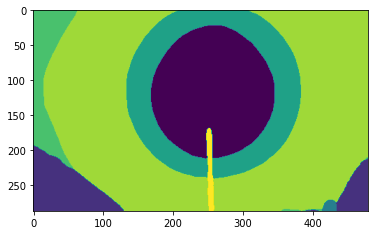

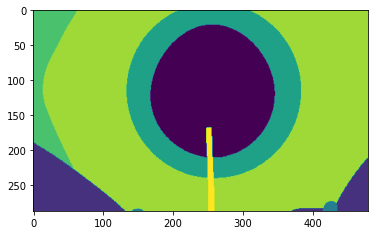

In [ ]:
images, masks = testset[190]
logits = new_model(images, masks)
logits = logits.permute(1,0,2,3)
predictions =  torch.nn.functional.softmax(logits[2], dim=0)
pred_labels = torch.argmax(predictions, dim=0)
plt.imshow(pred_labels.detach().cpu())
plt.show()


plt.imshow(masks[3])
plt.show()


In [ ]:
import sklearn.metrics as skm
def initialiseDictionary():
  labels = [0,1,2,3,4,5,6,7]
  label_stats = {}
  for label in labels:
    label_stats[label] = {'tp': 0, 'fn': 0, 'fp': 0}
  return label_stats

new_model.load_state_dict(torch.load('/content/drive/My Drive/Dissertation/conv_lstm_4.pt'))
stats =initialiseDictionary()

labels = [0,1,2,3,4,5,6,7]
for idx in range (0, len(testset)):
  
  images, masks = testset[idx]
  logits = new_model(images, masks)
  logits = logits.permute(1,0,2,3)
  
  predictions =  torch.nn.functional.softmax(logits[2], dim=0)
  pred_labels = torch.argmax(predictions, dim=0)
  

  prediction = pred_labels.to('cpu').flatten().numpy()
  
  ground_truth = masks[3].to('cpu').flatten().numpy()
  #print(set(prediction))

 

  conf_matrix = skm.multilabel_confusion_matrix(ground_truth, prediction,labels=labels)
  for label in labels:
    stats[label]['tp'] += conf_matrix[label][1][1] 
    stats[label]['fn'] += conf_matrix[label][1][0] 
    stats[label]['fp'] += conf_matrix[label][0][1] 



In [ ]:
for label in labels:
    tp = stats[label]['tp'] 
    fn = stats[label]['fn'] 
    fp = stats[label]['fp'] 
    iou = tp / ( fp + tp + fn)
    print(f"class {label} iou: {iou}")

class 0 iou: 0.9294606634042922
class 1 iou: 0.9473139501691084
class 2 iou: 0.9274749223246377
class 3 iou: 0.8811365883353552
class 4 iou: 0.8548181102483194
class 5 iou: 0.9278726592047332
class 6 iou: 0.9587628702007293
class 7 iou: 0.733648215006365


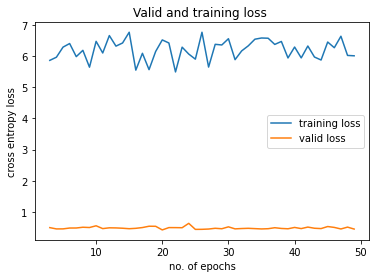

In [ ]:
epochs = range(3, EPOCHS)

# plotting the line 1 points 
plt.plot(epochs, train_losses[3:], label = "training loss")

# plotting the line 2 points 
plt.plot(epochs, valid_losses[3:], label = "valid loss")
plt.xlabel('no. of epochs')
# Set the y axis label of the current axis.
plt.ylabel('cross entropy loss')
# Set a title of the current axes.
plt.title('Valid and training loss ')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [24]:
# testing triplet loss 

new_model.load_state_dict(torch.load('/content/drive/My Drive/Dissertation/conv_lstm_4.pt'))
images, masks = testset[2]
logits = new_model(images, masks)
logits = logits.permute(1,0,2,3)

predictions =  torch.nn.functional.softmax(logits, dim=1)
# print(predictions[1])
# print(predictions.shape)
pred_labels = torch.argmax(predictions, dim=1)

# for label in pred_labels:
#   plt.imshow(label.cpu().numpy())
#   plt.show()


In [ ]:
dist = (pred_labels[3].flatten().unsqueeze(0) - pred_labels[2].flatten().unsqueeze(0)).pow(2).sum(1)
#print(np.square(pred_labels[3].cpu() - pred_labels[2].cpu()))
#sum_sq = np.sum((pred_labels[3].cpu().numpy()-pred_labels[2].cpu().numpy())**2)
sum_sq = np.sum((logits[0].detach().cpu().numpy()-logits[1].cpu().detach().numpy())**2)

print(logits[0].flatten().shape)
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)
output = triplet_loss(logits[3].flatten(), logits[4].flatten(), logits[5].flatten())
print(output)


torch.Size([1105920])
tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)


# Testing sequences on U-Net:


In [ ]:

from torch.autograd import Variable

def train_function(data_loader, model, optimizer):
  

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE, dtype=torch.long)
    # image = images[:,3,:,:,:]
    # mask = masks[:,3,:,:]
    # mask = mask.contiguous()
    # logits, loss = model(image, mask)
    # make sure gradients are 0
    optimizer.zero_grad()
    logits = []
 

    losses = []
    loss = 0
    count = 0

    #losses = torch.empty((6), dtype=torch.float)
    for i in range (0, 6):
      image = images[:,i,:,:,:] #iterate per frame
      mask = masks[:,i,:,:]
      
      mask = mask.contiguous()
      #loss_per_frame = LovaszLoss(mode = 'multiclass', ignore_index=-1)(logit, mask)
      logits, loss_per_frame = model(image, mask)
      loss += loss_per_frame
      count+=1
      
      #losses.append(loss_per_frame)

    #losses = torch.tensor(losses,dtype=torch.float, requires_grad=True).to(DEVICE)
    

    #loss = losses.mean()
    loss =  loss/count
    # print(loss)
    #loss = Variable(loss, requires_grad = True)

    loss.backward() #backpropagation


    optimizer.step() #update weights

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [ ]:
!nvidia-smi

Wed Dec 28 12:56:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    31W /  70W |  14982MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def eval_function(data_loader, model):


  model.eval() 
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE, dtype=torch.long)
      
      # image = images[:,3,:,:,:]
      # mask = masks[:,3,:,:]
      # mask = mask.contiguous()
      # logits, loss = model(image, mask)
        # make sure gradients are 0
     
      logits = []
      loss = 0
      count = 0
      #losses = []
      for i in range (0, 6):
        image = images[:,i,:,:,:] #iterate per frame
        mask = masks[:,i,:,:]
        mask = mask.contiguous()
        #loss_per_frame = LovaszLoss(mode = 'multiclass', ignore_index=-1)(logit, mask)
        logits, loss_per_frame = model(image, mask)
        loss += loss_per_frame
        count+=1
        #losses.append(loss_per_frame)

      #losses = torch.tensor(losses,dtype=torch.float).to(DEVICE)

      loss = loss/count 
      #loss = torch.mean(losses)
      #print(loss)


      total_loss += loss.item()

  return total_loss / len(data_loader)



In [ ]:
import gc
#new_model.cpu()
model.cpu()
#del new_model
del model
gc.collect()
torch.cuda.empty_cache()

In [ ]:
model = SegmentationModel()
model.to(DEVICE); 

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

lambda1 = lambda1 = lambda epoch : pow((1 - epoch / EPOCHS), 0.9)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer,lambda1) #polynomial




In [ ]:
EPOCHS = 50
best_valid_loss = np.Inf

valid_losses = []
train_losses = []

lrs = []


number_epoch_to_save = 5
steps = 50
for epoch in range(0,EPOCHS):


  
  train_loss = train_function(trainloader, model, optimizer)
  valid_loss = eval_function(validloader, model)
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)


  if valid_loss < best_valid_loss: #if best valid loss then upate new model
    torch.save(model.state_dict(), f'/content/drive/My Drive/Dissertation/practice.pt')
    print("Saved model")
    best_valid_loss = valid_loss

  scheduler.step()


  if epoch % number_epoch_to_save == 0:

    torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': valid_loss,
              'best_loss': best_valid_loss,
              'train_loss': train_loss
              }, '/content/drive/My Drive/Dissertation/practice_current.pt')
  
  lrs.append(scheduler.get_last_lr())
  print(f"Epoch : {epoch+1} Train_loss : {train_loss} Valid_loss : {valid_loss} Learning rate: {scheduler.get_last_lr()} ")



100%|██████████| 134/134 [00:50<00:00,  2.65it/s]


Saved model
Epoch : 1 Train_loss : 0.43955697706144936 Valid_loss : 0.3196860432847222 Learning rate: [0.0009819818665965754] 


  9%|▉         | 75/848 [01:15<12:57,  1.01s/it]


KeyboardInterrupt: ignored

# Extra code

In [ ]:

training_images = (glob.glob(f"/content/Takeout/Drive/Data/Training/*.npz"))
testing_images = (glob.glob(f"/content/Takeout/Drive/Data/Testing/*.npz"))
validation_images = glob.glob(f"/content/Takeout/Drive/Data/Validation/*.npz")


for i in range(0,len(testing_images)):
  print(i)
  path = testing_images[i]
  array = np.load(path)
  images = array['images']
  masks = array['masks']
  image_name = os.path.split(path)[1].replace(".npz", "")
  
  
  for i in range (0,7):
    image = images[i, :, : ,:].transpose(1,2,0) * 255.0
    mask = masks[i, :, :]
    mask[mask == -1] = 8
  
    
    cv2.imwrite(f'/content/Takeout/Drive/Data/Resized_Images/Testing/Images/{image_name}_frame{i}.png', cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

    cv2.imwrite(f'/content/Takeout/Drive/Data/Resized_Images/Testing/Masks/{image_name}_frame{i}.png', mask)
    
  
  
  


In [ ]:
def generateImagesMasks(image_name, split):
  
  image_paths = sorted(glob.glob(f"/content/Takeout/Drive/Data/Resized_Images/{split}/Images/{image_name}*"))
  mask_paths = sorted(glob.glob(f"/content/Takeout/Drive/Data/Resized_Images/{split}/Masks/{image_name}*"))
  
  images = []
  masks = []
  
  for path in image_paths:
      image = cv2.imread(path)
      image = (cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255.0).astype(np.float32)
      image = image.transpose(2,0,1)
      images.append(image)
      
  for path in mask_paths:
      mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
      
      masks.append(mask)
  
  
  masks = np.stack(masks, axis=0)
  images = np.stack(images,axis=0)
  return images, masks